import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
%matplotlib inline
import pickle

from astropy import units as u
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord
from astropy.wcs.utils import skycoord_to_pixel
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from morpheus.classifier import Classifier
from morpheus.data import example

# 1. Getting Data

## Getting HST 3D-HST Data

In [4]:
f115w_nircam_i2d = (get_pkg_data_filename('/data/jip/2nd_TASK/Morpheus_Trying/JWST_cutout_img_analysis/img/jw01345-o002_t022_nircam_clear-f115w_i2d.fits'))
f150w_nircam_i2d = (get_pkg_data_filename('/data/jip/2nd_TASK/Morpheus_Trying/JWST_cutout_img_analysis/img/jw01345-o002_t022_nircam_clear-f150w_i2d.fits'))
f200w_nircam_i2d = (get_pkg_data_filename('/data/jip/2nd_TASK/Morpheus_Trying/JWST_cutout_img_analysis/img/jw01345-o002_t022_nircam_clear-f200w_i2d.fits'))
f277w_nircam_i2d = (get_pkg_data_filename('/data/jip/2nd_TASK/Morpheus_Trying/JWST_cutout_img_analysis/img/jw01345-o002_t022_nircam_clear-f277w_i2d.fits'))
f356w_nircam_i2d = (get_pkg_data_filename('/data/jip/2nd_TASK/Morpheus_Trying/JWST_cutout_img_analysis/img/jw01345-o002_t022_nircam_clear-f356w_i2d.fits'))
f410m_nircam_i2d = (get_pkg_data_filename('/data/jip/2nd_TASK/Morpheus_Trying/JWST_cutout_img_analysis/img/jw01345-o002_t022_nircam_clear-f410m_i2d.fits'))
f444w_nircam_i2d = (get_pkg_data_filename('/data/jip/2nd_TASK/Morpheus_Trying/JWST_cutout_img_analysis/img/jw01345-o002_t022_nircam_clear-f444w_i2d.fits'))


f140w_wfc3_orig_sci = get_pkg_data_filename('/data/jip/2nd_TASK/Morpheus_Trying/VisualMorphologyTest/3D-HST/HLSP/hlsp_3dhst_hst_wfc3_aegis_f140w_v4.0_orig-sci/hlsp_3dhst_hst_wfc3_aegis_f140w_v4.0_orig-sci.fits')


h, j, v, z = f140w_wfc3_orig_sci, f140w_wfc3_orig_sci, f140w_wfc3_orig_sci, f140w_wfc3_orig_sci

# fits 특성에 따라서 ext 바꿔줘야 
hdat = fits.getdata(h, ext=0)
jdat = fits.getdata(j, ext=0)
vdat = fits.getdata(v, ext=0)
zdat = fits.getdata(z, ext=0)

h_header = fits.getheader(h, ext=0)
j_header = fits.getheader(j, ext=0)
v_header = fits.getheader(v, ext=0)
z_header = fits.getheader(z, ext=0)

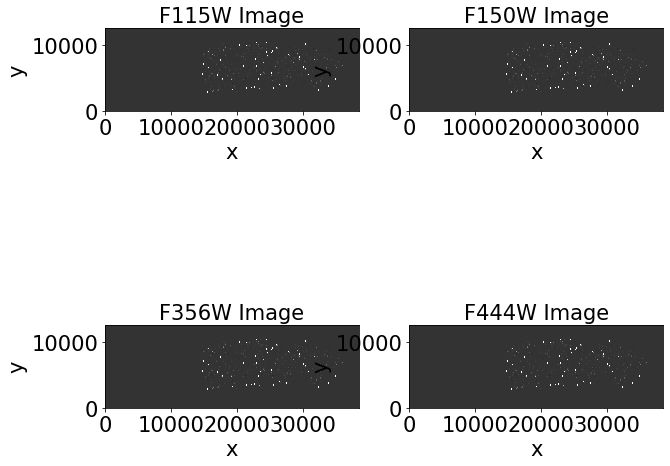

In [4]:
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes = np.array(axes).flatten()
for ax, arr, band in zip(axes, [hdat, jdat, vdat, zdat], ['F115W', 'F150W', 'F356W', 'F444W']):
    ax.set_title(f'{band} Image', fontsize=21)
    ax.imshow(arr, origin='lower', cmap='gray',  vmin=-0.1, vmax=0.4)
    ax.set_xlabel('x', fontsize=21)
    ax.set_ylabel('y', fontsize=21)
    ax.tick_params(axis='x', labelsize=21)
    ax.tick_params(axis='y', labelsize=21)

# 2. Synthesize Image size/field

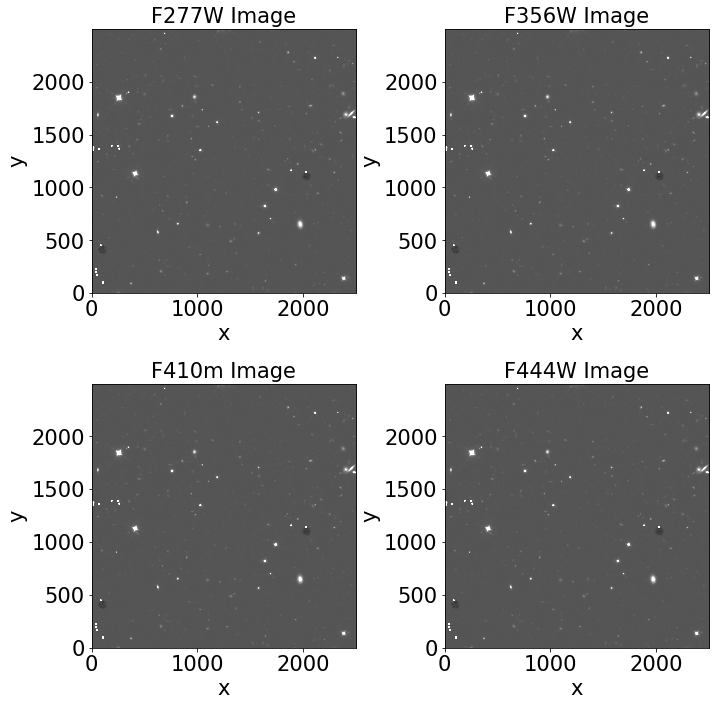

In [5]:
cutoutposition = (20500, 5000)   # (2500, 1000) size (2000, 4000)
cutoutsize = (2500, 2500)
hcut = Cutout2D(hdat, cutoutposition, cutoutsize).data
jcut = Cutout2D(jdat, cutoutposition, cutoutsize).data
vcut = Cutout2D(vdat, cutoutposition, cutoutsize).data
zcut = Cutout2D(zdat, cutoutposition, cutoutsize).data
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes = np.array(axes).flatten()

for ax, arr, band in zip(axes, [hcut,jcut,vcut,zcut], ['F277W', 'F356W', 'F410m', 'F444W']):
    ax.set_title(f'{band} Image', fontsize=21)
    ax.imshow(arr, origin='lower', cmap='gray',  vmin=-0.3, vmax=0.6)
    ax.set_xlabel('x', fontsize=21)
    ax.set_ylabel('y', fontsize=21)
    ax.tick_params(axis='x', labelsize=21)
    ax.tick_params(axis='y', labelsize=21)

plt.tight_layout()
plt.show()

# Catalog Data

Morpheus Catalog based on 3D-HST survey

In [6]:
cat = pd.read_csv('/data/jip/2nd_TASK/Morpheus_Trying/VisualMorphologyTest/3D-HST/morpheus_EGS_value_added_catalog_rip.csv')

In [7]:
tempsktp = skycoord_to_pixel(SkyCoord(cat['ra']*u.deg, cat['dec']*u.deg), wcs=WCS(h_header))
cat['real_x']=tempsktp[0]
cat['real_y']=tempsktp[1]
cat['x'] = cat['real_x']-(cutoutposition[0]-cutoutsize[1]/2) 
cat['y'] = cat['real_y']-(cutoutposition[1]-cutoutsize[0]/2) # 왜인지 모르겟으나 cutoutsize가 (y, x)임 
cat['new_id'] = cat['id']-1 #id가 dataframe 표시 순서랑 연동되는 편리한 놈 생성
cat = cat.loc[cat['x'] < cutoutsize[1]] #지금은 cutoutsize가 (y, x)로 나오고 있어 이게 맞다
cat = cat.loc[cat['x'] > 0]
cat = cat.loc[cat['y'] < cutoutsize[0]]
cat = cat.loc[cat['y'] > 0]

real_x , real_y = x, y in original h,j,v,z image

x, y = x, y in hcut,jcut,vcut,zcut image

# 3. Runnning Morpheus

In [9]:
def source_morpheus_run(x, y, cutsize, hdat, jdat, vdat, zdat, h_header):
    cp = (x, y)
    cs = (cutsize, cutsize)
    hcut2 = Cutout2D(hdat, cp, cs).data
    jcut2 = Cutout2D(jdat, cp, cs).data
    vcut2 = Cutout2D(vdat, cp, cs).data
    zcut2 = Cutout2D(zdat, cp, cs).data
    classified = Classifier.classify(h=hcut2, j=jcut2, v=vcut2, z=zcut2)
    # the mask tells the segmentation mapping algorithm to ignore
    # the areas unclassified as a result of the windowing classification
    # method used.
    mask = np.zeros_like(hcut2, np.int)
    mask[5:-5, 5:-5] = 1
    segmap = Classifier.segmap_from_classified(classified, hcut2, mask=mask)
    catalog = Classifier.catalog_from_classified(classified, hcut2, segmap)
    rgb = Classifier.colorize_classified(classified)

    wcs = WCS(h_header)

    morpheus_result = pd.DataFrame(catalog)
    morpheus_result['ra'] = pd.Series(dtype='float')
    morpheus_result['dec'] = pd.Series(dtype='float')
    morpheus_result['x'] = pd.Series(dtype='float')
    morpheus_result['y'] = pd.Series(dtype='float')
    morpheus_result['p_sph'] = pd.Series(dtype='float')
    morpheus_result['p_disk'] = pd.Series(dtype='float')
    morpheus_result['p_irr'] = pd.Series(dtype='float')
    morpheus_result['p_ps'] = pd.Series(dtype='float')

    for i in range(np.size(morpheus_result['ra'])):
        morpheus_result['x'][i] = morpheus_result['location'][i][1]
        morpheus_result['y'][i] = morpheus_result['location'][i][0]
        morpheus_result['p_sph'][i] = morpheus_result['morphology'][i][0]
        morpheus_result['p_disk'][i] = morpheus_result['morphology'][i][1]
        morpheus_result['p_irr'][i] = morpheus_result['morphology'][i][2]
        morpheus_result['p_ps'][i] = morpheus_result['morphology'][i][3]
    

    # == 지금 왜인지는 모르겟으나 a.ipynb에서 cutoutsize가 (y, x로 찍히는 걸 생각할 것)
    morpheus_result['real_x'] = morpheus_result['x']+(cp[0]-cs[1]/2)
    morpheus_result['real_y'] = morpheus_result['y']+(cp[1]-cs[0]/2)

    for i in range(np.size(morpheus_result['ra'])):
        morpheus_result['ra'][i] = pixel_to_skycoord(morpheus_result['real_x'][i], morpheus_result['real_y'][i], wcs).ra.degree
        morpheus_result['dec'][i] = pixel_to_skycoord(morpheus_result['real_x'][i], morpheus_result['real_y'][i], wcs).dec.degree
    
    return morpheus_result


In [ ]:
from tqdm import tqdm 
from IPython.display import clear_output

df = pd.DataFrame(columns =['id','location','morphology','ra','dec','x','y','p_sph','p_disk','p_irr','p_ps','real_x','real_y'])

for i in tqdm(cat['new_id']):
    add = source_morpheus_run(cat['real_x'][i], cat['real_y'][i], cutsize=50, hdat=hdat, jdat=jdat, vdat=vdat, zdat=zdat, h_header=h_header)
    df = pd.concat([df, add])
    clear_output(wait=True)

100%|██████████| 1274/1274 [31:09<00:00,  1.47s/it]


# 4. Saving Morpheus Result / Import Morpheus Result

### Save

In [108]:
with open('df_3DHST_cutsize=50.pickle', 'wb') as f:
    pickle.dump(df, f)

### Load

In [12]:
import pickle 
with open('/data/jip/2nd_TASK/Morpheus_Trying/VisualMorphologyTest/3D-HST/df_3DHST_cutsize=50.pickle', 'rb') as f:
    df = pickle.load(f)
 

# 5. Analyze Result

## 1) Matching Catalog and Morpheus Result

In [13]:
class matchingdfcat:
    def __init__(self, dat_df, dat_catalog):  # def __init__(self, dat_df, dat_catalog, tolerance)
        tol = 0.6/3600 #RA/DEC (deg?)     # tol = tolerance / 3600
        ra_s, dec_s = dat_df['ra'], dat_df['dec']
        ra_c, dec_c = dat_catalog['ra'], dat_catalog['dec']
        src = SkyCoord(ra=ra_s*u.degree, dec=dec_s*u.degree)    # coordinates from SExtractor
        cat = SkyCoord(ra=ra_c*u.degree, dec=dec_c*u.degree)    # coordinates from catalogs
        idx, sep2d, dist3d = match_coordinates_sky(src, cat, nthneighbor=1, storekdtree='kdtree_sky')    # 매칭 함수 실행

        matched = sep2d.value < tol    # 매칭 조건 적용
        self.n_mch = np.sum(matched)    # 매칭된 개수
        self.idx_cat = idx[matched]    # cat의 매칭된 인덱스
        self.idx_src = np.where(matched)[0]    # src의 매칭된 인덱스

    def matcheddf(self, dat_df):
        return dat_df.iloc[self.idx_src]

    def matcheddf_index(self):
        return self.idx_src

    def matchedcat(self, dat_catalog):
        return dat_catalog.iloc[self.idx_cat]

    def matchedcat_index(self):
        return self.idx_cat

    def matchedsize(self):
        return self.n_mch

In [14]:
x = matchingdfcat(df, cat)

total source

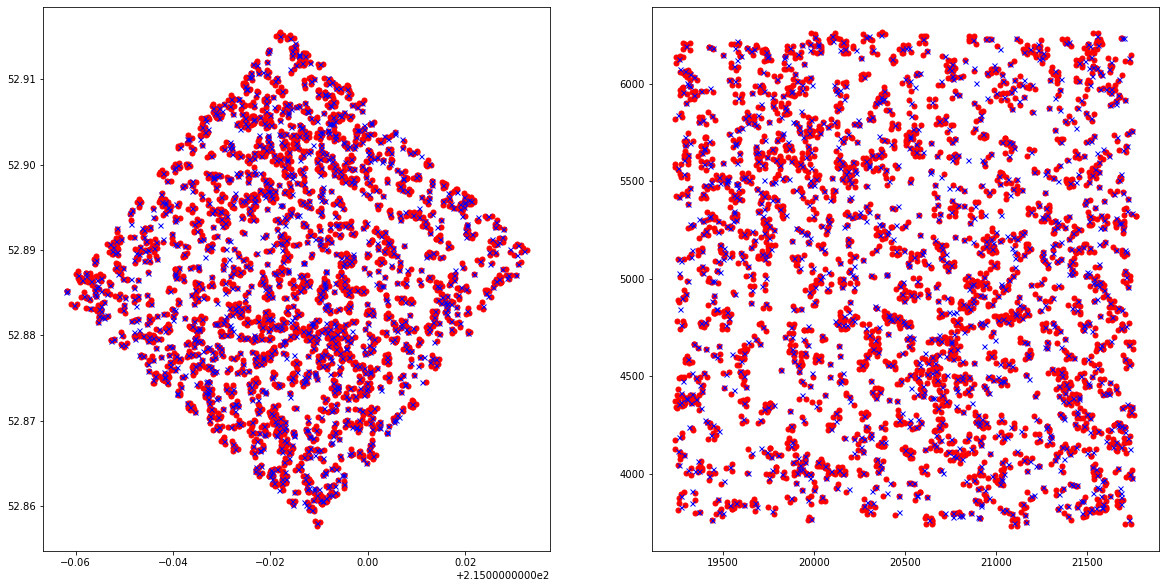

In [15]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax[0].plot(df['ra'], df['dec'], 'o', color='red', ms=5)
ax[0].plot((cat)['ra'], (cat)['dec'], 'x', color='blue', ms=5)
ax[1].plot(df['real_x'], df['real_y'], 'o', color='red', ms=5)
ax[1].plot((cat)['real_x'], (cat)['real_y'], 'x', color='blue', ms=5)

matched source

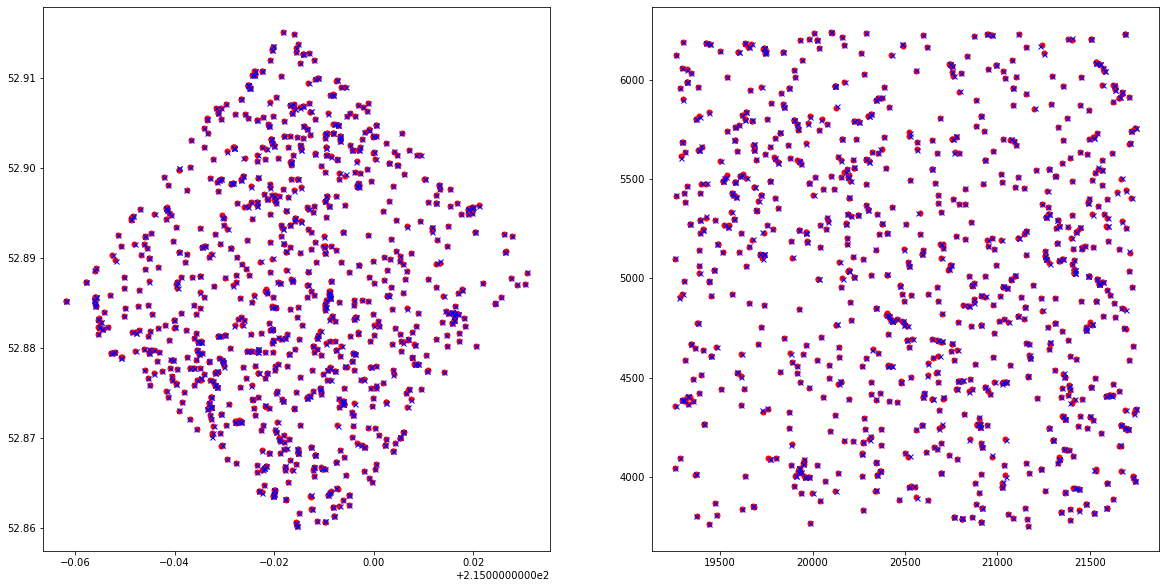

In [16]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax[0].plot(x.matcheddf(df)['ra'], x.matcheddf(df)['dec'], 'o', color='red', ms=5)
ax[0].plot(x.matchedcat(cat)['ra'], x.matchedcat(cat)['dec'], 'x', color='blue', ms=5)
ax[1].plot(x.matcheddf(df)['real_x'], x.matcheddf(df)['real_y'], 'o', color='red', ms=5)
ax[1].plot(x.matchedcat(cat)['real_x'], x.matchedcat(cat)['real_y'], 'x', color='blue', ms=5)

## 2) Result to Table

In [17]:
matched_df = x.matcheddf(df)[['ra', 'dec', 'p_sph', 'p_disk', 'p_irr', 'p_ps', 'real_x', 'real_y']]
matched_cat = x.matchedcat(cat)[['ra', 'dec', 'spheroid', 'disk', 'irregular', 'ps_compact', 'real_x', 'real_y','h_f160w_ab_mag']]
matched_df = matched_df.reset_index(drop=True)
matched_cat = matched_cat.reset_index(drop=True)

In [39]:
df_residual = pd.DataFrame(0, index=np.arange(np.size(matched_df['ra'])), columns =['del_ra','del_dec','del_psph','del_pdisk','del_pirr','del_pcom','del_px','del_py', 'ra_mor', 'dec_mor', 'ra_cat', 'dec_cat'])

In [40]:
from tqdm import tqdm
for i in tqdm(range(np.size(matched_df['ra']))):
    df_residual['del_ra'][i]=matched_df['ra'][i]-matched_cat['ra'][i]
    df_residual['del_dec'][i]=matched_df['dec'][i]-matched_cat['dec'][i]
    df_residual['del_psph'][i]=matched_df['p_sph'][i]-matched_cat['spheroid'][i]
    df_residual['del_pdisk'][i]=matched_df['p_disk'][i]-matched_cat['disk'][i]
    df_residual['del_pirr'][i]=matched_df['p_irr'][i]-matched_cat['irregular'][i]
    df_residual['del_pcom'][i]=matched_df['p_ps'][i]-matched_cat['ps_compact'][i]
    df_residual['del_px'][i]=matched_df['real_x'][i]-matched_cat['real_x'][i]
    df_residual['del_py'][i]=matched_df['real_y'][i]-matched_cat['real_y'][i]
    df_residual['ra_mor'][i] = matched_df['ra'][i]
    df_residual['dec_mor'][i] = matched_df['dec'][i]
    df_residual['ra_cat'][i] = matched_cat['ra'][i]
    df_residual['dec_cat'][i] = matched_cat['dec'][i]

  0%|          | 0/1027 [00:00<?, ?it/s]/tmp/ipykernel_42461/1054990394.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_residual['del_dec'][i]=matched_df['dec'][i]-matched_cat['dec'][i]
/tmp/ipykernel_42461/1054990394.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_residual['del_psph'][i]=matched_df['p_sph'][i]-matched_cat['spheroid'][i]
/tmp/ipykernel_42461/1054990394.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

(array([ 31.,  28.,  32., 447., 165.,  93.,  65., 165.,   0.,   1.]),
 array([-0.9497649 , -0.69245606, -0.43514723, -0.17783839,  0.07947045,
         0.33677929,  0.59408812,  0.85139696,  1.1087058 ,  1.36601463,
         1.62332347]),
 <BarContainer object of 10 artists>)

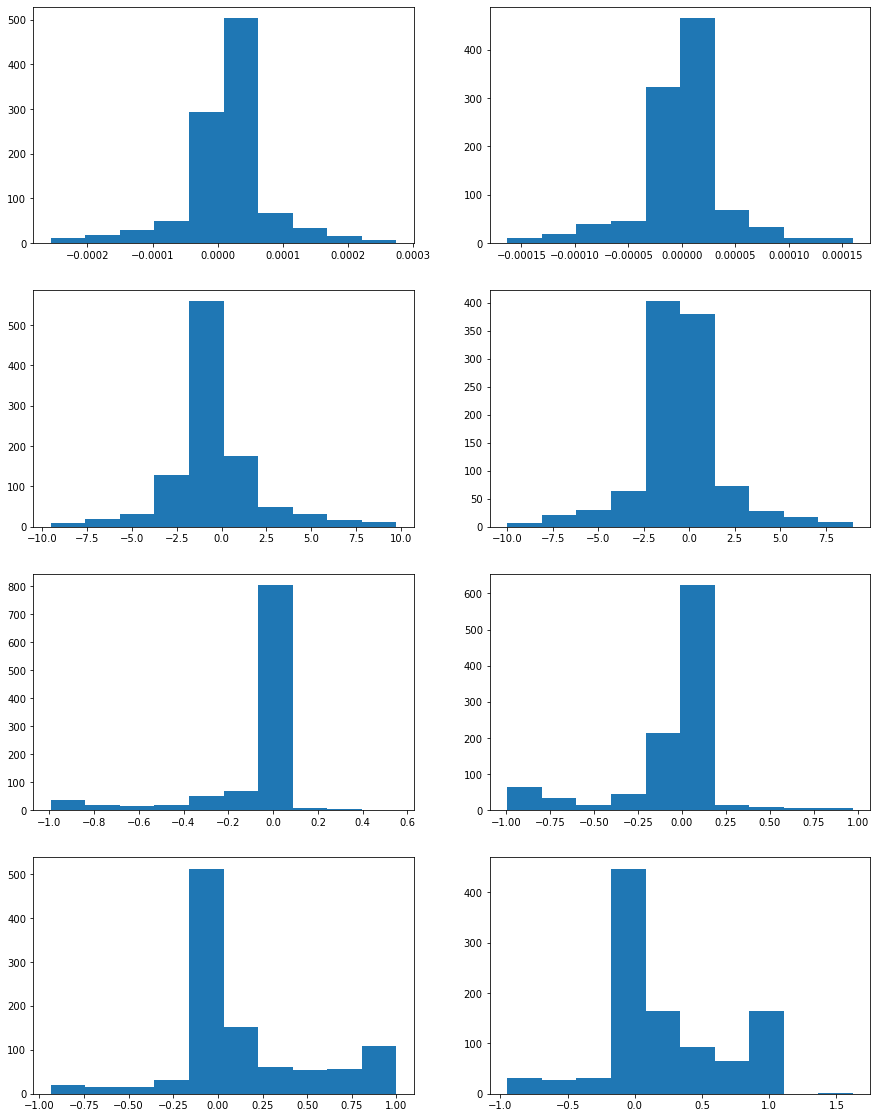

In [41]:
f, ax = plt.subplots(nrows=4, ncols=2, figsize=(15,20))
ax[0,0].hist(df_residual['del_ra'])
ax[0,1].hist(df_residual['del_dec'])
ax[1,0].hist(df_residual['del_px'])
ax[1,1].hist(df_residual['del_py'])
ax[2,0].hist(df_residual['del_psph'])
ax[2,1].hist(df_residual['del_pdisk'])
ax[3,0].hist(df_residual['del_pirr'])
ax[3,1].hist(df_residual['del_pcom'])


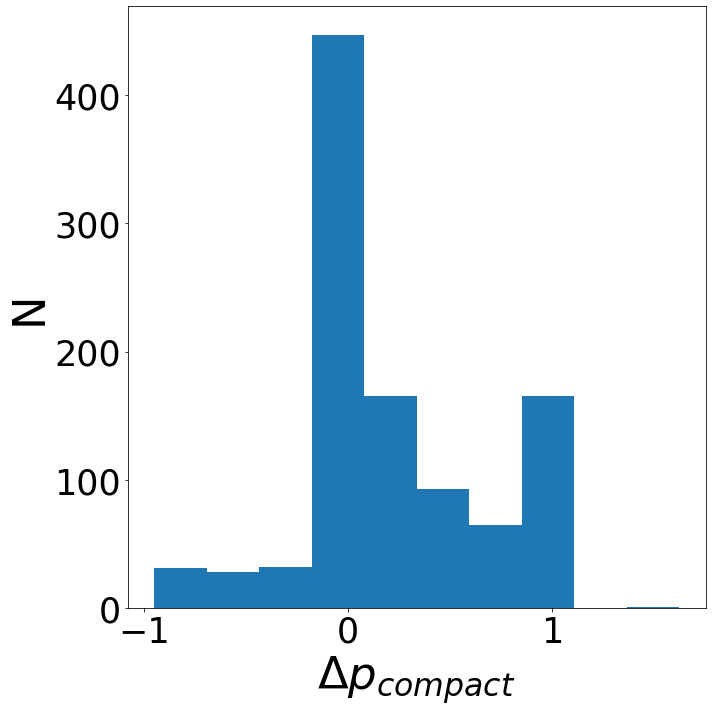

In [21]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
ax.hist(df_residual['del_pcom'], bins=10)
ax.tick_params(axis='both', which='major', labelsize=35)
ax.set_xlabel('$\Delta p_{compact}$', fontsize=45)
ax.set_ylabel('N', fontsize=45)

plt.tight_layout()

## 3) Make Region File for Visual Morphology

Selecting disk candidates from result

In [22]:
matched_df_disk = matched_df[matched_df['p_disk']>0.5]
matched_cat_disk = matched_cat[matched_cat['disk']>0.5]
matched_cat_disk = matched_cat[matched_cat['h_f160w_ab_mag']<24.5]

#### Morpheus Result - disk

In [23]:
f = open('disk_Morpheus_3D_HST.reg', 'w')

wcs_r=WCS(h_header)

dataoption = matched_df
src2 = skycoord_to_pixel(SkyCoord(dataoption['ra']*u.deg, dataoption['dec']*u.deg), wcs=wcs_r)
src1 = np.transpose(src2)
src1 = pd.DataFrame(src1, columns=['x', 'y'])
for i in np.arange(len(src1)):
    f.write('image;circle(%.2f, %.2f, 20) \n' %(src1['x'][i], src1['y'][i]))
    # 이미지에서 source의 x, y 좌표를 중심으로 한 20 pixel 반경의 원을 display하여 보여주는 region file 쓰기

f.close()


### 디스플레이 방법: DS9 - Region - Load regions - 'test.reg' 열기

#### 3D-HST Catalog Result (Morpheus Site Release) - disk

In [24]:
f = open('disk_3D-HST_cat.reg', 'w')
dataoption = matched_cat_disk

wcs_r=WCS(h_header)

src2 = skycoord_to_pixel(SkyCoord(dataoption['ra']*u.deg, dataoption['dec']*u.deg), wcs=wcs_r)
src1 = np.transpose(src2)
src1 = pd.DataFrame(src1, columns=['x', 'y'])
for i in np.arange(len(src1)):
    f.write('image;circle(%.2f, %.2f, 20) \n' %(src1['x'][i], src1['y'][i]))
    # 이미지에서 source의 x, y 좌표를 중심으로 한 20 pixel 반경의 원을 display하여 보여주는 region file 쓰기

f.close()


### 디스플레이 방법: DS9 - Region - Load regions - 'test.reg' 열기

#### Error Analysis (뭔가 이상하게 튀어 나온 값들 다시 reg 파일로 표시 후 알아보기)

In [54]:
df_residual_error = df_residual[abs(df_residual['del_psph'])>0.5]

(array([ 31.,  28.,  32., 447., 165.,  93.,  65., 165.,   0.,   1.]),
 array([-0.9497649 , -0.69245606, -0.43514723, -0.17783839,  0.07947045,
         0.33677929,  0.59408812,  0.85139696,  1.1087058 ,  1.36601463,
         1.62332347]),
 <BarContainer object of 10 artists>)

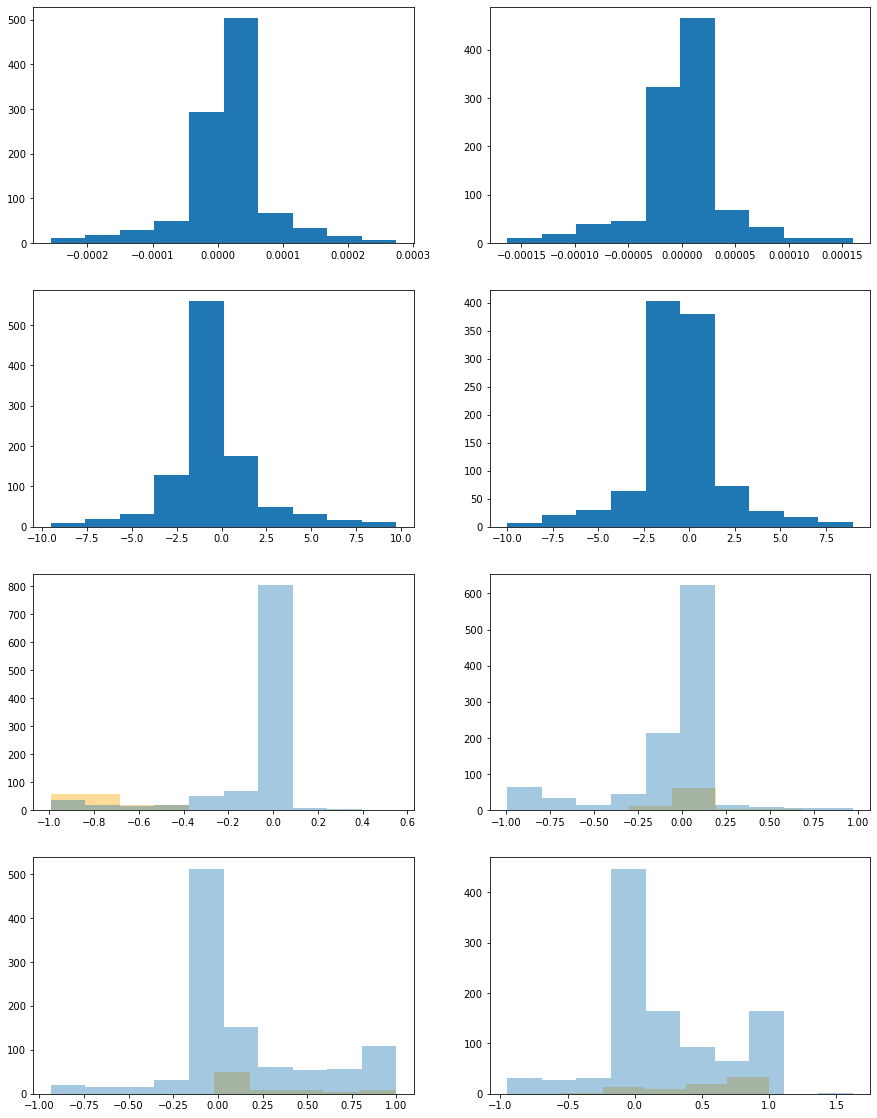

In [55]:
f, ax = plt.subplots(nrows=4, ncols=2, figsize=(15,20))
ax[2,0].hist(df_residual_error['del_psph'], alpha=0.4, color='orange', bins=5)
ax[2,1].hist(df_residual_error['del_pdisk'], alpha=0.4, color='orange', bins=5)
ax[3,0].hist(df_residual_error['del_pirr'], alpha=0.4, color='orange', bins=5)
ax[3,1].hist(df_residual_error['del_pcom'], alpha=0.4, color='orange', bins=5)


ax[0,0].hist(df_residual['del_ra'])
ax[0,1].hist(df_residual['del_dec'])
ax[1,0].hist(df_residual['del_px'])
ax[1,1].hist(df_residual['del_py'])

ax[2,0].hist(df_residual['del_psph'], alpha=0.4)
ax[2,1].hist(df_residual['del_pdisk'], alpha=0.4)
ax[3,0].hist(df_residual['del_pirr'], alpha=0.4)
ax[3,1].hist(df_residual['del_pcom'], alpha=0.4)

In [27]:
f = open('error_disk_3D-HST.reg', 'w')
dataoption = df_residual_error

wcs_r=WCS(h_header)

src2 = skycoord_to_pixel(SkyCoord(dataoption['ra_mor']*u.deg, dataoption['dec_mor']*u.deg), wcs=wcs_r)
src1 = np.transpose(src2)
src1 = pd.DataFrame(src1, columns=['x', 'y'])
for i in np.arange(len(src1)):
    f.write('image;circle(%.2f, %.2f, 20) # color=blue\n' %(src1['x'][i], src1['y'][i]))
    # 이미지에서 source의 x, y 좌표를 중심으로 한 20 pixel 반경의 원을 display하여 보여주는 region file 쓰기

f.close()


### 디스플레이 방법: DS9 - Region - Load regions - 'test.reg' 열기

Error 난 녀석들 Plot 해서 특성 파악하기

In [ ]:
psph_err = df_residual[abs(df_residual['del_psph'])>0.5]
pdisk_err = df_residual[abs(df_residual['del_pdisk'])>0.5]
pirr_err = df_residual[abs(df_residual['del_pirr'])>0.5]
pcom_err = df_residual[abs(df_residual['del_pcom'])>0.5]

(array([ 31.,  18.,   0.,   0.,   0.,  38.,  65., 165.,   0.,   1.]),
 array([-0.9497649 , -0.69245606, -0.43514723, -0.17783839,  0.07947045,
         0.33677929,  0.59408812,  0.85139696,  1.1087058 ,  1.36601463,
         1.62332347]),
 <BarContainer object of 10 artists>)

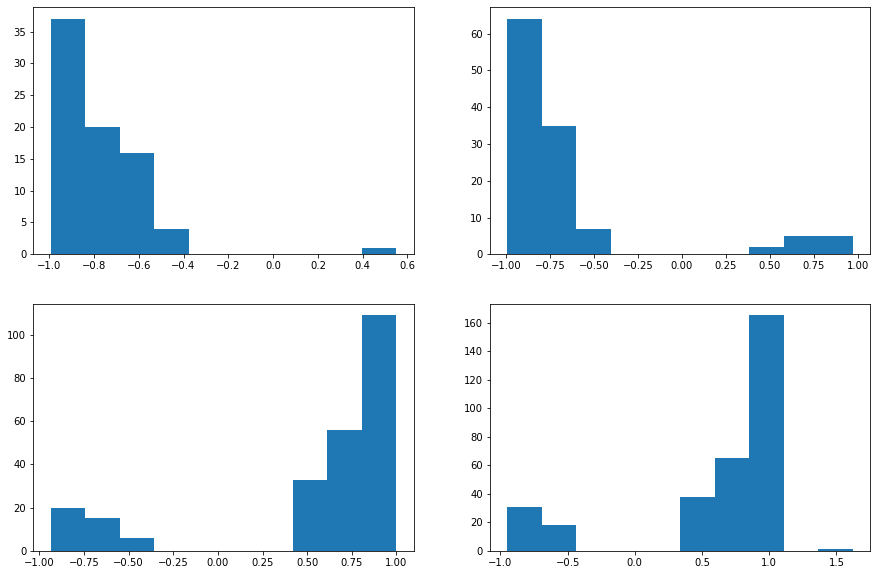

In [62]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax[0,0].hist(psph_err['del_psph'])
ax[0,1].hist(pdisk_err['del_pdisk'])
ax[1,0].hist(pirr_err['del_pirr'])
ax[1,1].hist(pcom_err['del_pcom'])



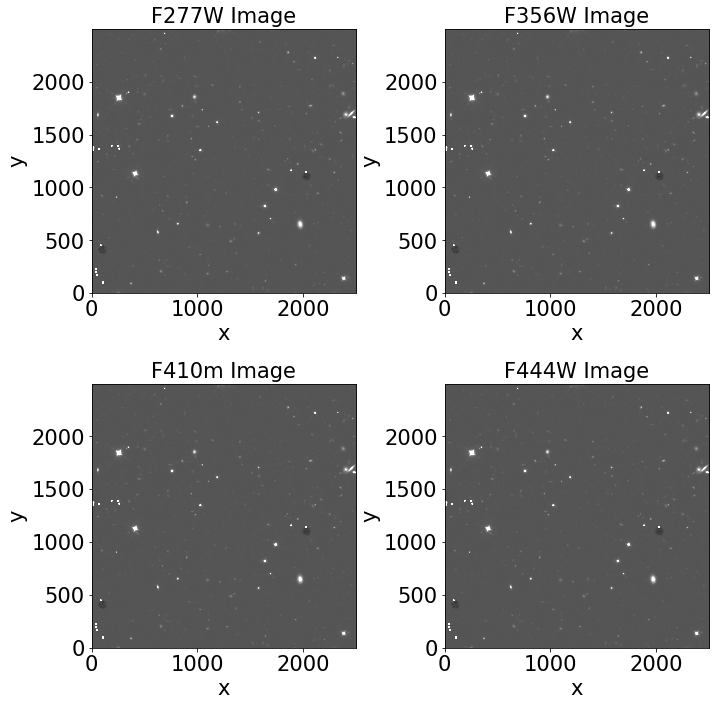

In [63]:
cutoutposition = (20500, 5000)   # (2500, 1000) size (2000, 4000)
cutoutsize = (2500, 2500)
hcut = Cutout2D(hdat, cutoutposition, cutoutsize).data
jcut = Cutout2D(jdat, cutoutposition, cutoutsize).data
vcut = Cutout2D(vdat, cutoutposition, cutoutsize).data
zcut = Cutout2D(zdat, cutoutposition, cutoutsize).data
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes = np.array(axes).flatten()

for ax, arr, band in zip(axes, [hcut,jcut,vcut,zcut], ['F277W', 'F356W', 'F410m', 'F444W']):
    ax.set_title(f'{band} Image', fontsize=21)
    ax.imshow(arr, origin='lower', cmap='gray',  vmin=-0.3, vmax=0.6)
    ax.set_xlabel('x', fontsize=21)
    ax.set_ylabel('y', fontsize=21)
    ax.tick_params(axis='x', labelsize=21)
    ax.tick_params(axis='y', labelsize=21)

plt.tight_layout()
plt.show()

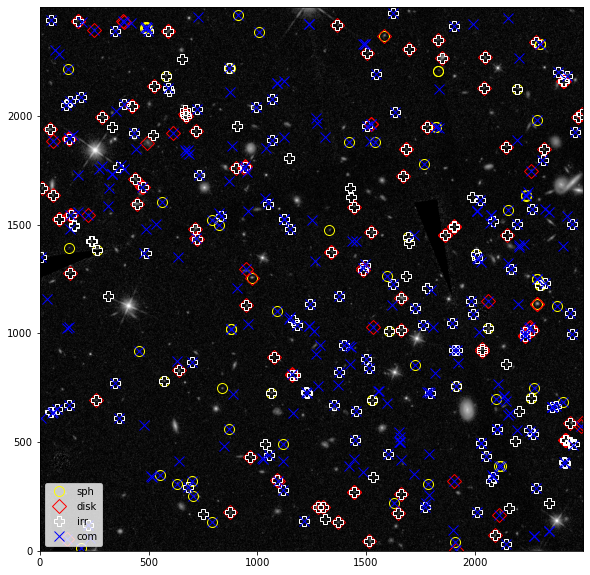

In [123]:
from astropy.visualization import make_lupton_rgb

wcs_r = WCS(h_header)

f, ax = plt.subplots(1, 1, figsize=(10,10))


image = make_lupton_rgb(hcut, jcut, vcut, stretch=0.1)
ax.imshow(image, origin='lower')

ax.plot(skycoord_to_pixel(SkyCoord(psph_err['ra_mor']*u.deg, psph_err['dec_mor']*u.deg), wcs=wcs_r)[0]-cutoutposition[0]+cutoutsize[0]/2,skycoord_to_pixel(SkyCoord(psph_err['ra_mor']*u.deg, psph_err['dec_mor']*u.deg), wcs=wcs_r)[1]-cutoutposition[1]+cutoutsize[1]/2,'o',ms=10, color='yellow', fillstyle='none', label='sph')
ax.plot(skycoord_to_pixel(SkyCoord(pdisk_err['ra_mor']*u.deg, pdisk_err['dec_mor']*u.deg), wcs=wcs_r)[0]-cutoutposition[0]+cutoutsize[0]/2,skycoord_to_pixel(SkyCoord(pdisk_err['ra_mor']*u.deg, pdisk_err['dec_mor']*u.deg), wcs=wcs_r)[1]-cutoutposition[1]+cutoutsize[1]/2,'D',ms=10, color='red', fillstyle='none', label='disk')
ax.plot(skycoord_to_pixel(SkyCoord(pirr_err['ra_mor']*u.deg, pirr_err['dec_mor']*u.deg), wcs=wcs_r)[0]-cutoutposition[0]+cutoutsize[0]/2,skycoord_to_pixel(SkyCoord(pirr_err['ra_mor']*u.deg, pirr_err['dec_mor']*u.deg), wcs=wcs_r)[1]-cutoutposition[1]+cutoutsize[1]/2,'P',ms=10, color='white', fillstyle='none', label='irr')
ax.plot(skycoord_to_pixel(SkyCoord(pcom_err['ra_mor']*u.deg, pcom_err['dec_mor']*u.deg), wcs=wcs_r)[0]-cutoutposition[0]+cutoutsize[0]/2,skycoord_to_pixel(SkyCoord(pcom_err['ra_mor']*u.deg, pcom_err['dec_mor']*u.deg), wcs=wcs_r)[1]-cutoutposition[1]+cutoutsize[1]/2,'x',ms=10, color='blue', fillstyle='none', label='com')
ax.legend(fontsize=10)